# Objective: Predict Housing Prices
Target: Price

# Imports

In [6]:
# if you need these
#!pip install statsmodels
#!pip install xgboost

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing / Global Variables

In [8]:
df = pd.read_csv("Housing.csv")

df = df.replace({"yes": 1, "no": 0}).infer_objects(copy=False) # map qualitative 'yes' and 'no' to boolean variables
df['furnishingstatus'] = df['furnishingstatus'].map({'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0})
df = df.dropna() # remove null entries if they exist

/var/folders/fv/08fkmb2n3ps3vq7cjrywq5840000gn/T/ipykernel_95580/3667572300.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"yes": 1, "no": 0}).infer_objects(copy=False) # map qualitative 'yes' and 'no' to boolean variables


In [9]:
# always use this KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Exploratory Data Analysis

/var/folders/fv/08fkmb2n3ps3vq7cjrywq5840000gn/T/ipykernel_95580/2961014468.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)


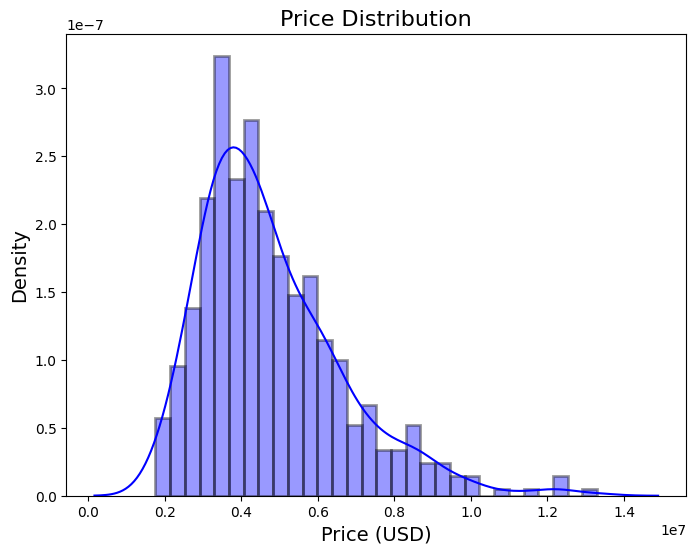

In [10]:
# analyze the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.distplot(df['price'], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Price Distribution')
plt.xlabel('Price (USD)');

In [11]:
df['price'].describe()

count    5.450000e+02
mean     4.766729e+06
std      1.870440e+06
min      1.750000e+06
25%      3.430000e+06
50%      4.340000e+06
75%      5.740000e+06
max      1.330000e+07
Name: price, dtype: float64

/var/folders/fv/08fkmb2n3ps3vq7cjrywq5840000gn/T/ipykernel_95580/478361809.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['area'], color='g', hist_kws=dict(edgecolor="black", linewidth=2), bins=30)


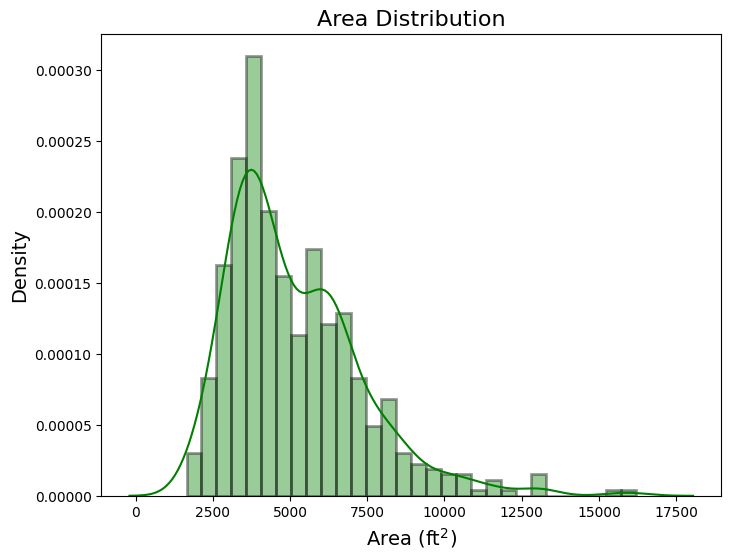

In [12]:
# analyze the distribution of the "area" variable
plt.figure(figsize=(8, 6))
sns.distplot(df['area'], color='g', hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Area Distribution')
plt.xlabel('Area (ft$^2$)');

In [13]:
df['area'].describe()

count      545.000000
mean      5150.541284
std       2170.141023
min       1650.000000
25%       3600.000000
50%       4600.000000
75%       6360.000000
max      16200.000000
Name: area, dtype: float64

### Plot to get an idea of the underlying relationship between price and area

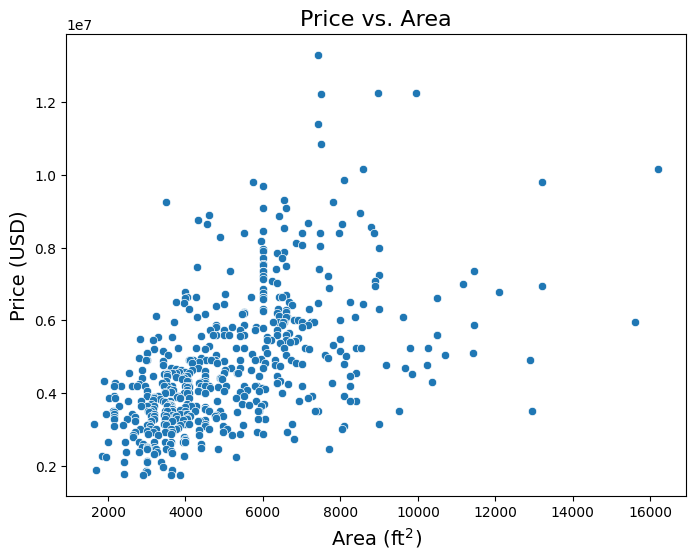

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area', y='price', data=df)
plt.title('Price vs. Area')
plt.xlabel('Area (ft$^2$)')
plt.ylabel('Price (USD)');

It's clear there's some kind of relationship, but it's not quite linear... yet!

In [15]:
# transform price and area
df['log_area'] = np.log1p(df['area']) # from testing, log appears to work best
X = df.drop(['price', 'area'], axis=1) # remove target (price) and regular area
y = np.log1p(df['price'])  # log(1 + price)

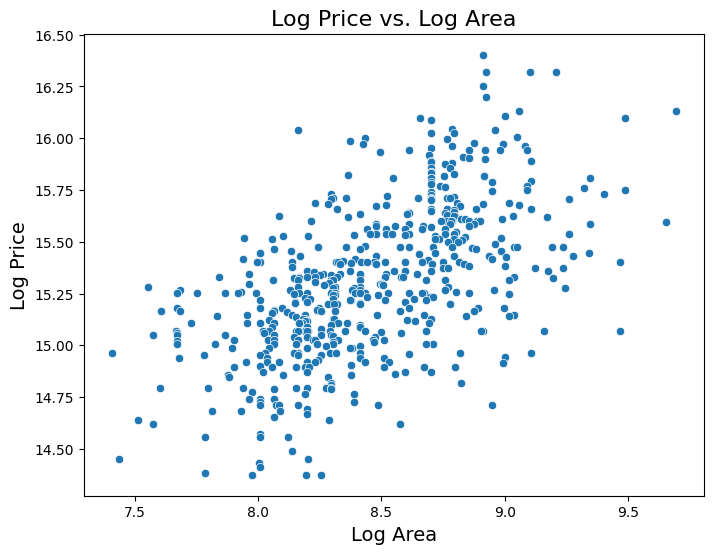

In [16]:
# plot to show the improvement
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['log_area'], y=y)
plt.title('Log Price vs. Log Area')
plt.xlabel('Log Area')
plt.ylabel('Log Price');

Now that's much better!

### Run standard linear regression as a benchmark

In [17]:
# run linear regression with cross validation and return rmse and r^2
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

def lin_regression(X, y):
    y_pred_lr = cross_val_predict(pipeline_lr, X, y, cv=kf)
    
    rmse_lr = np.sqrt(mean_squared_error(y, y_pred_lr))
    r2_lr = r2_score(y, y_pred_lr)
    
    return rmse_lr, r2_lr

In [18]:
rmse_basic_lr, r2_basic_lr = lin_regression(X, y)
print(f"RMSE: {rmse_basic_lr:.3f}, R^2: {r2_basic_lr:.3f}")

RMSE: 0.210, R^2: 0.681


Not terrible, but also not great. Let's see if we can improve.

# Multicollinearity

We suspect high degrees of multicollinearity in our data. Let's try to identify it and fix it if it's there.

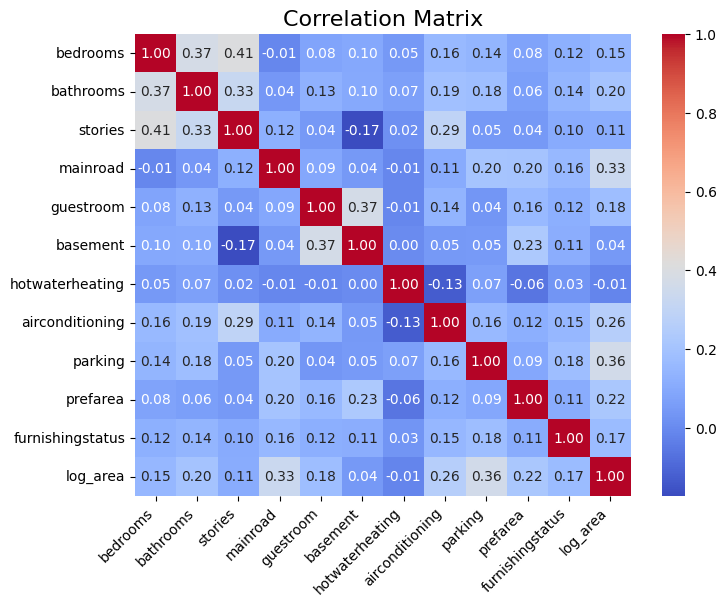

In [19]:
# correlation matrix
corr_matrix = X.corr()

# correlation heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Correlation Matrix');

In [20]:
# top ten most correlated features
rows, cols = np.triu_indices(len(corr_matrix), k=1)
upper_entries = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) for i, j in zip(rows, cols)]
upper_entries_df = pd.DataFrame(upper_entries, columns=["Feature 1", "Feature 2", "Correlation"])
upper_entries_df = upper_entries_df.sort_values(by="Correlation", key=lambda x: x.abs(), ascending=False).reset_index(drop=True)
upper_entries_df.head(10)

,Feature 1,Feature 2,Correlation
0,bedrooms,stories,0.408564
1,bedrooms,bathrooms,0.373930
2,guestroom,basement,0.372066
3,parking,log_area,0.360776
4,mainroad,log_area,0.331598
5,bathrooms,stories,0.326165
6,stories,airconditioning,0.293602
7,airconditioning,log_area,0.262420
8,basement,prefarea,0.228083
9,prefarea,log_area,0.219716


Some features are correlated, but not as strongly as we suspected. Next, we try Variance Inflation Factor (VIF), a single metric for each feature that represents its multicollinearity.

In [21]:
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df = vif_df.sort_values(by="VIF", ascending=False)
vif_df.reset_index(drop=True)

,Feature,VIF
0,log_area,27.473329
1,bedrooms,23.366429
2,bathrooms,9.707789
3,mainroad,8.313206
4,stories,7.847374
5,furnishingstatus,2.729168
6,basement,2.016101
7,parking,1.851449
8,airconditioning,1.729400
9,guestroom,1.461638


We see that log_area and bedrooms have the highest VIF by far. Theoretically, this means that we can remove one or both of these entirely from the dataset, and the model's performance will stay the same (or improve).

In [22]:
# remove log_area entirely
X_no_area = X.drop(columns=["log_area"])
rmse_no_area, r2_no_area = lin_regression(X_no_area, y)
print(f"RMSE: {rmse_no_area:.3f}, R^2: {r2_no_area:.3f}")

RMSE: 0.233, R^2: 0.606


In [23]:
# remove bedrooms entirely
X_no_bedrooms = X.drop(columns=["bedrooms"])
rmse_no_bedrooms, r2_no_bedrooms = lin_regression(X_no_bedrooms, y)
print(f"RMSE: {rmse_no_bedrooms:.3f}, R^2: {r2_no_bedrooms:.3f}")

RMSE: 0.210, R^2: 0.681


In [24]:
# remove both log_area and bedrooms entirely
X_no_area_bedrooms = X.drop(columns=["log_area", "bedrooms"])
rmse_no_area_bedrooms, r2_no_area_bedrooms = lin_regression(X_no_area_bedrooms, y)
print(f"RMSE: {rmse_no_area_bedrooms:.3f}, R^2: {r2_no_area_bedrooms:.3f}")

RMSE: 0.234, R^2: 0.602


Removing only log_area as well as removing both log_area and bedrooms had a fairly drastic negative effect, but removing only bedrooms actually did not affect performance. We will keep it in as it may be helpful later.

# Feature Importance

### Random Forest

In [25]:
forest = RandomForestRegressor(n_estimators=1000, max_features=12, random_state=42)

forest.fit(X, y)
importances = forest.feature_importances_

# create a DataFrame to show feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
importances_df.reset_index(drop=True)

,Feature,Importance
0,log_area,0.489057
1,bathrooms,0.117389
2,furnishingstatus,0.088186
3,airconditioning,0.051585
4,stories,0.048410
5,parking,0.045214
6,bedrooms,0.044780
7,prefarea,0.035039
8,basement,0.034883
9,mainroad,0.016384


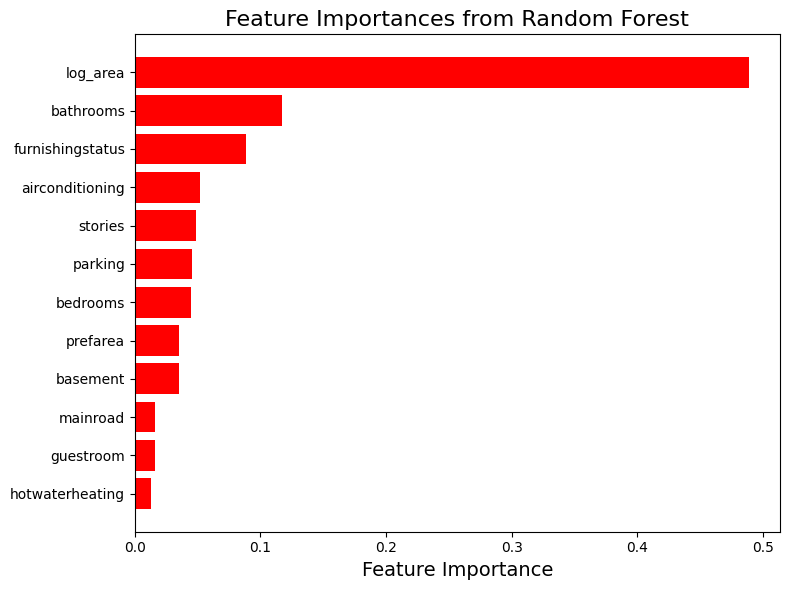

In [26]:
plt.figure(figsize=(8, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='red')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [27]:
# random forest with cross validation
y_pred_forest = cross_val_predict(forest, X, y, cv=kf)

rmse_forest = np.sqrt(mean_squared_error(y, y_pred_forest))
r2_forest = r2_score(y, y_pred_forest)

print(f"RMSE: {rmse_forest:.3f}, R^2: {r2_forest:.3f}")

RMSE: 0.223, R^2: 0.641


Not bad, but not as good as linear regression.

### Ridge Regression

In [28]:
alphas_ridge = np.logspace(-2, 2, 400)
ridge_cv = RidgeCV(alphas=alphas_ridge, store_cv_results=True)

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ridge_cv)
])

pipeline_ridge.fit(X, y)

optimal_alpha_ridge = pipeline_ridge.named_steps['ridge'].alpha_
coefs_ridge = pipeline_ridge.named_steps['ridge'].coef_

print(f"Optimal alpha: {optimal_alpha_ridge}")
print("Model coefficients:")
coef_df_ridge = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefs_ridge
}).sort_values(by="Coefficient", ascending=False).reset_index(drop=True)
coef_df_ridge

Optimal alpha: 24.46082935796798
Model coefficients:


,Feature,Coefficient
0,log_area,0.114068
1,bathrooms,0.079138
2,stories,0.074354
3,airconditioning,0.072020
4,prefarea,0.053624
5,furnishingstatus,0.045188
6,basement,0.044167
7,parking,0.037474
8,mainroad,0.034653
9,hotwaterheating,0.034234


In [29]:
# evaluate the model
pipeline_ridge_fixed = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=optimal_alpha_ridge))
])

y_pred_ridge = cross_val_predict(pipeline_ridge_fixed, X, y, cv=kf)

rmse_ridge = np.sqrt(mean_squared_error(y, y_pred_ridge))
r2_ridge = r2_score(y, y_pred_ridge)

print(f"RMSE: {rmse_ridge:.3f}, R^2: {r2_ridge:.3f}")

RMSE: 0.210, R^2: 0.682


This matches our best performance so far!

### Lasso Regression

In [30]:
alphas_lasso = np.logspace(-5, 0, 400)
lasso_cv = LassoCV(alphas=alphas_lasso)

pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', lasso_cv)
])

pipeline_lasso.fit(X, y)

optimal_alpha_lasso = pipeline_lasso.named_steps['lasso'].alpha_
coefs_lasso = pipeline_lasso.named_steps['lasso'].coef_

print(f"Optimal alpha: {optimal_alpha_lasso}")
print("Model coefficients:")
coef_df_lasso = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefs_lasso
}).sort_values(by="Coefficient", ascending=False).reset_index(drop=True)
coef_df_lasso

Optimal alpha: 1e-05
Model coefficients:


,Feature,Coefficient
0,log_area,0.118738
1,bathrooms,0.081026
2,stories,0.077483
3,airconditioning,0.073336
4,prefarea,0.054632
5,basement,0.046675
6,furnishingstatus,0.045829
7,parking,0.036813
8,hotwaterheating,0.035955
9,mainroad,0.033891


In [31]:
# evaluate the model
pipeline_lasso_fixed = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=optimal_alpha_lasso))
])

y_pred_lasso = cross_val_predict(pipeline_lasso_fixed, X, y, cv=kf)

rmse_lasso = np.sqrt(mean_squared_error(y, y_pred_lasso))
r2_lasso = r2_score(y, y_pred_lasso)

print(f"RMSE: {rmse_lasso:.3f}, R^2: {r2_lasso:.3f}")

RMSE: 0.210, R^2: 0.681


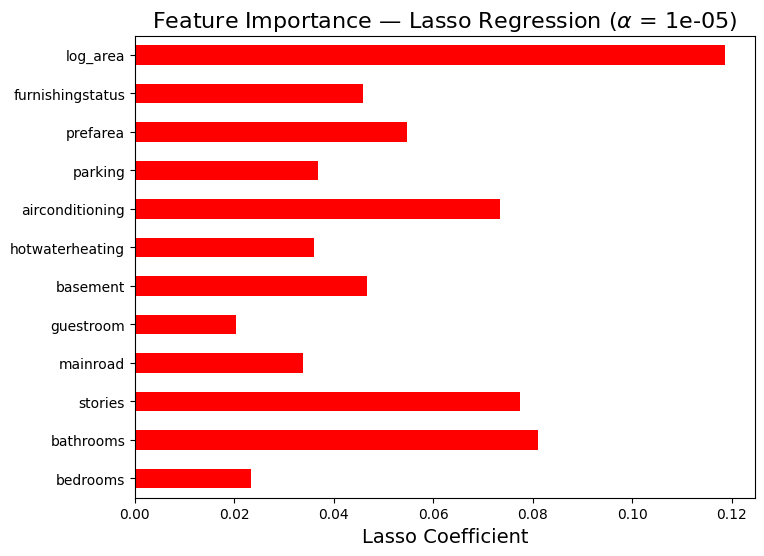

In [32]:
coefs_lasso_series = pd.Series(coefs_lasso, index = X.columns)
plt.figure(figsize=(8, 6))
coefs_lasso_series.plot(kind = 'barh', color = 'red')
plt.title(rf"Feature Importance — Lasso Regression ($\alpha$ = {optimal_alpha_lasso})")
plt.xlabel('Lasso Coefficient');

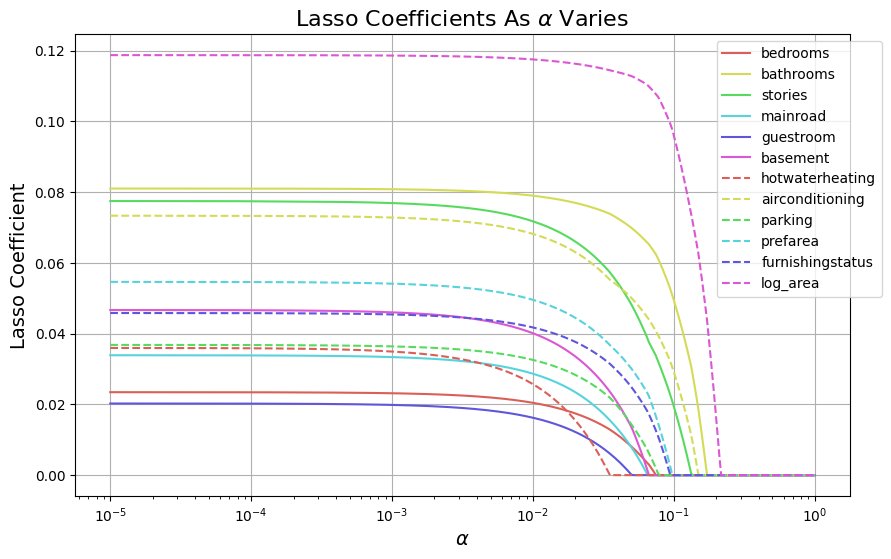

In [43]:
coefs = []

# Fit Lasso for each alpha and store coefficients
for a in alphas_lasso:
    lasso = Lasso(alpha=a, max_iter=10000)
    pipeline_lasso_fixed = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', lasso)
    ])
    pipeline_lasso_fixed.fit(X, y)
    coefs.append(pipeline_lasso_fixed.named_steps['lasso'].coef_)

# Plot
plt.figure(figsize=(10, 6))
ax = plt.gca()
coefs = np.array(coefs)

feature_names = X.columns

colors = sns.color_palette("hls", 6)
for i in range(coefs.shape[1]):
    color = colors[i % 6]
    linestyle = '-' if i < 6 else '--'
    ax.plot(alphas_lasso, coefs[:, i], color=color, linestyle=linestyle, label=feature_names[i])

ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Lasso Coefficient')
plt.title(r'Lasso Coefficients As $\alpha$ Varies')
plt.axis('tight')
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1);

### Comparing important features of linear regression vs. ridge vs. lasso

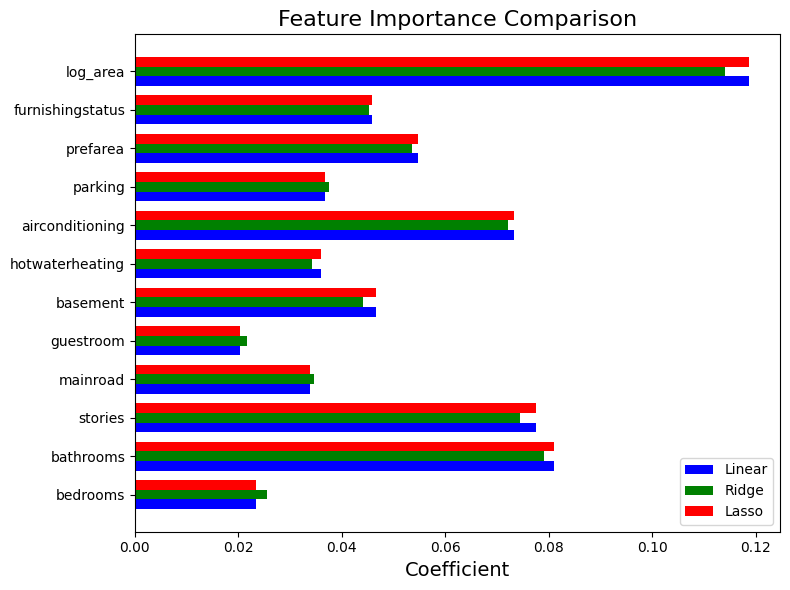

In [220]:
pipeline_lr.fit(X, y)
coefs_lr = pipeline_lr.named_steps['regressor'].coef_

coefs_lr_series = pd.Series(coefs_lr, index=X.columns)
coefs_ridge_series = pd.Series(coefs_ridge, index=X.columns)
coefs_lasso_series = pd.Series(coefs_lasso, index=X.columns)

features = X.columns
y_pos = np.arange(len(features))  # y-axis positions
height = 0.25  # bar height

plt.figure(figsize=(8, 6))

plt.barh(y_pos - height, coefs_lr_series, height, label='Linear', color='blue')
plt.barh(y_pos, coefs_ridge_series, height, label='Ridge', color='green')
plt.barh(y_pos + height, coefs_lasso_series, height, label='Lasso', color='red')

plt.yticks(y_pos, features)
plt.xlabel('Coefficient')
plt.title('Feature Importance Comparison')
plt.legend()
plt.tight_layout()

### XGBoost

In [221]:
boost_model = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=1
)

y_pred_boost = cross_val_predict(boost_model, X, y, cv=kf)

rmse_boost = np.sqrt(mean_squared_error(y, y_pred_boost))
r2_boost = r2_score(y, y_pred_boost)

print(f"RMSE: {rmse_boost:.3f}, R^2: {r2_boost:.3f}")

RMSE: 0.210, R^2: 0.682


Around the same as before.

# Additional Models

### Support Vector Regression (SVR)

In [222]:
# SVR with cross validation
# test for linear, rbf, and polynomial models,
# as well as different values for kernel and C

pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid_svr = {
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__C': np.logspace(-2, 1, 20),
    'svr__epsilon': np.logspace(-2, 1, 20)
}

grid_search_svr = GridSearchCV(
    pipeline_svr,
    param_grid=param_grid_svr,
    cv=kf,
    scoring='r2',
    refit='r2',
    n_jobs=-1
)

grid_search_svr.fit(X, y)

best_model_svr = grid_search_svr.best_estimator_
y_pred_svr = cross_val_predict(best_model_svr, X, y, cv=kf)

rmse_svr = np.sqrt(mean_squared_error(y, y_pred_svr))
r2_svr = r2_score(y, y_pred_svr)

print(f"RMSE: {rmse_svr:.3f}, R^2: {r2_svr:.3f}")

RMSE: 0.209, R^2: 0.684


Same performance as before.

### Principal Component Analysis (PCA)

In [223]:
pipeline_pca_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('reg', Ridge())
])

param_grid_pca_ridge = {
    'pca__n_components': range(1, len(X.columns) + 1),
    'reg__alpha': np.logspace(-2, 2, 20)
}

grid_search_pca_ridge = GridSearchCV(
    pipeline_pca_ridge,
    param_grid=param_grid_pca_ridge,
    cv=kf,
    scoring='r2',
    refit='r2',
    n_jobs=-1
)

grid_search_pca_ridge.fit(X, y)

best_model_pca_ridge = grid_search_pca_ridge.best_estimator_
y_pred_pca_ridge = cross_val_predict(best_model_pca_ridge, X, y, cv=kf)

rmse_pca_ridge = np.sqrt(mean_squared_error(y, y_pred_pca_ridge))
r2_pca_ridge = r2_score(y, y_pred_pca_ridge)

print(f"Best n_components: {grid_search_pca_ridge.best_params_['pca__n_components']}")
print(f"RMSE: {rmse_pca_ridge:.3f}, R^2: {r2_pca_ridge:.3f}")

Best n_components: 12
RMSE: 0.210, R^2: 0.682


Extracting 12 principal components from all 12 features has the best performance.

In [224]:
pipeline_pca_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svr', SVR())
])

param_grid_pca_svr = {
    'pca__n_components': range(1, len(X.columns) + 1),
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__C': np.logspace(-2, 1, 20),
    'svr__epsilon': np.logspace(-2, 1, 20)
}

grid_search_pca_svr = GridSearchCV(
    pipeline_pca_svr,
    param_grid=param_grid_pca_svr,
    cv=kf,
    scoring='r2',
    refit='r2',
    n_jobs=-1
)

grid_search_pca_svr.fit(X, y)

best_model_pca_svr = grid_search_pca_svr.best_estimator_
y_pred_pca_svr = cross_val_predict(best_model_pca_svr, X, y, cv=kf)

rmse_pca_svr = np.sqrt(mean_squared_error(y, y_pred_pca_svr))
r2_pca_svr = r2_score(y, y_pred_pca_svr)

print(f"Best n_components: {grid_search_pca_svr.best_params_['pca__n_components']}")
print(f"RMSE: {rmse_pca_svr:.3f}, R^2: {r2_pca_svr:.3f}")

Best n_components: 12
RMSE: 0.209, R^2: 0.684


n_components = 12 wins again.

# Comparing All Methods

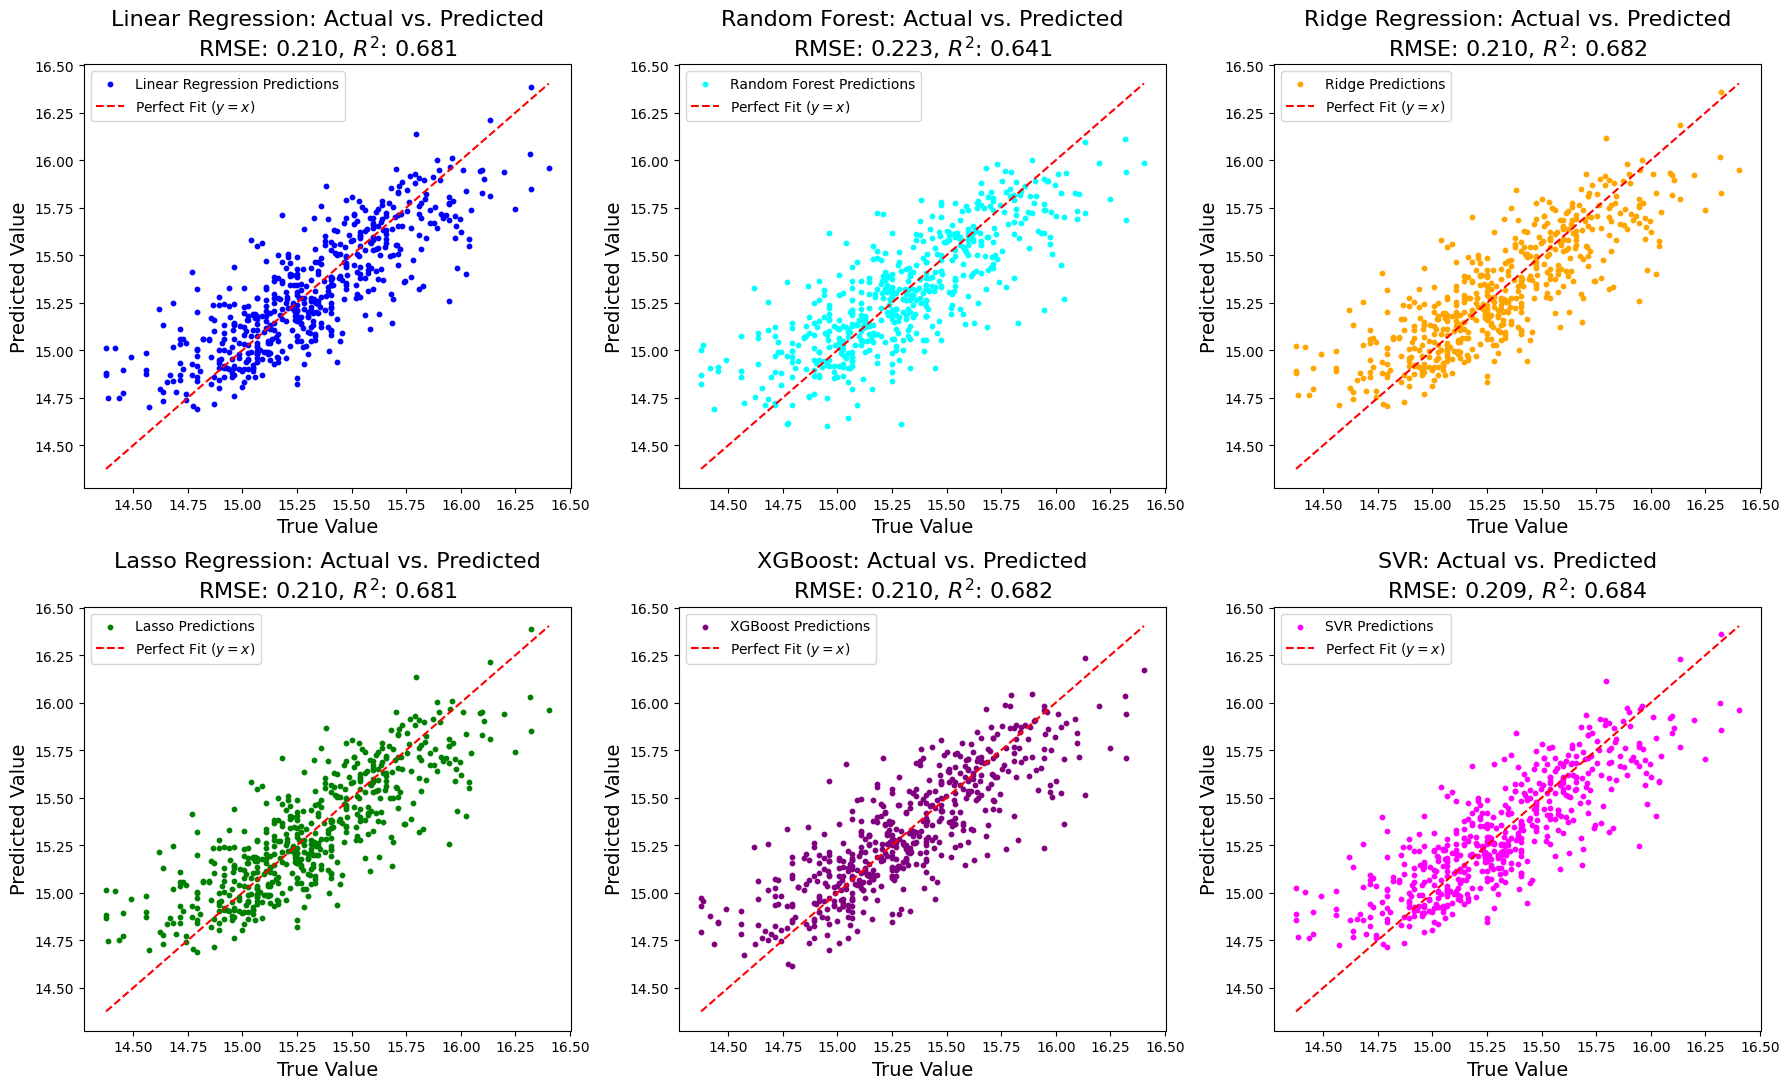

In [237]:
# never got linear regression predictions
y_pred_lr = cross_val_predict(pipeline_lr, X, y, cv=kf)

plt.figure(figsize=(18, 11))

# plot Linear Regression predictions vs. actual
plt.subplot(2, 3, 1)
plt.scatter(y, y_pred_lr, color='blue', label="Linear Regression Predictions", s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Fit ($y=x$)")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title(f'Linear Regression: Actual vs. Predicted\nRMSE: {rmse_basic_lr:.3f}, $R^2$: {r2_basic_lr:.3f}')
plt.legend()

# plot Random Forest predictions vs. actual
plt.subplot(2, 3, 2)
plt.scatter(y, y_pred_forest, color='cyan', label="Random Forest Predictions", s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Fit ($y=x$)")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title(f'Random Forest: Actual vs. Predicted\nRMSE: {rmse_forest:.3f}, $R^2$: {r2_forest:.3f}')
plt.legend()

# plot Ridge predictions vs. actual
plt.subplot(2, 3, 3)
plt.scatter(y, y_pred_ridge, color='orange', label="Ridge Predictions", s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Fit ($y=x$)")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title(f'Ridge Regression: Actual vs. Predicted\nRMSE: {rmse_ridge:.3f}, $R^2$: {r2_ridge:.3f}')
plt.legend()

# plot Lasso predictions vs. actual
plt.subplot(2, 3, 4)
plt.scatter(y, y_pred_lasso, color='green', label="Lasso Predictions", s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Fit ($y=x$)")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title(f'Lasso Regression: Actual vs. Predicted\nRMSE: {rmse_lasso:.3f}, $R^2$: {r2_lasso:.3f}')
plt.legend()

# plot XGBoost predictions vs. actual
plt.subplot(2, 3, 5)
plt.scatter(y, y_pred_boost, color='purple', label="XGBoost Predictions", s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Fit ($y=x$)")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title(f'XGBoost: Actual vs. Predicted\nRMSE: {rmse_boost:.3f}, $R^2$: {r2_boost:.3f}')
plt.legend()

# plot SVR predictions vs. actual
plt.subplot(2, 3, 6)
plt.scatter(y, y_pred_svr, color='magenta', label="SVR Predictions", s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Fit ($y=x$)")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title(f'SVR: Actual vs. Predicted\nRMSE: {rmse_svr:.3f}, $R^2$: {r2_svr:.3f}')
plt.legend()

plt.tight_layout()

In [226]:
# brute force PCA on every possible subset of features
# i.e., only extracting principal components from certain features

from itertools import combinations

def all_combinations(features):
    result = []
    n = len(features)
    for r in range(2, n + 1):
        result.extend([list(c) for c in combinations(features, r)])
    return result

def brute_force_PCA(X, y, all_combos, model):
    def PCA_on(pca_features, n_components):
        pca_features_df = X[pca_features]
        other_features = X.drop(columns=pca_features)
        
        scaler_X = StandardScaler()
        pca_scaled = scaler_X.fit_transform(pca_features_df)
        
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(pca_scaled)
        
        pca_df = pd.DataFrame(pca_result, columns=[f"PC{i + 1}" for i in range(n_components)], index=df.index)
        final_df = pd.concat([pca_df, other_features], axis=1)
        
        rmse, r2 = model(final_df, y)
        return rmse, r2
    
    feature_combos = pd.DataFrame(columns=["Features", "n_components", "RMSE", "R2"])
    for combo in all_combos:
        for n in range(1, len(combo)):
            rmse, r2 = PCA_on(combo, n)
            feature_combos = pd.concat([feature_combos, pd.DataFrame([[", ".join(combo), n, rmse, r2]], \
                                                                     columns=["Features", "n_components", "RMSE", "R2"])], ignore_index=True)
    return feature_combos.sort_values(by="R2", ascending=False)

In [227]:
# brute force PCA, feeding into Linear Regression
#pca_lin_regression = brute_force_PCA(X, y, all_combinations(X.columns), lin_regression)
#pca_lin_regression.to_csv("Brute Force PCA (Linear Regression).csv", index=False)
pca_lin_regression = pd.read_csv("Brute Force PCA (Linear Regression).csv")
pca_lin_regression.head(10)

,Features,n_components,RMSE,R2
0,"bathrooms, basement, airconditioning",1,0.208052,0.686909
1,"bedrooms, mainroad, basement, prefarea, furnis...",1,0.208300,0.686164
2,"bathrooms, stories, guestroom, hotwaterheating...",2,0.208327,0.686080
3,"bedrooms, mainroad, basement, parking, prefare...",2,0.208344,0.686030
4,"bathrooms, stories, airconditioning, furnishin...",1,0.208365,0.685967
5,"bathrooms, mainroad, basement, airconditioning",1,0.208371,0.685949
6,"bedrooms, mainroad, basement, parking, prefarea",2,0.208372,0.685944
7,"bathrooms, stories, basement, airconditioning,...",3,0.208405,0.685846
8,"bedrooms, mainroad, basement, prefarea",1,0.208421,0.685798
9,"bathrooms, stories, guestroom, airconditioning...",2,0.208453,0.685702


Extracting one principal component from the bathrooms, basement, and airconditioning features had the best results, giving slightly better performance than SVR alone.